# DisperseNN2 workflow for predicting dispersal for a ship rat dataset

## 1. Start off by creating a new conda environment and then install disperseNN2 with pip.

In [ ]:
conda create --prefix /$Workdir/dispersal_inference/disperseNN2 python=3.9 --yes
conda activate /$Workdir/dispersal_inference/disperseNN2

pip install disperseNN2

## 2. Generate the simulation data to train the model. 

This is the driver script for generating simulation data using SLiM. The simulations are arrayed, in batches of 5, due to memory and resource limits on the server, thus 100 sims requires 20 arrays. 
``sbatch --array=1-20 00_SLiMulations_k50_10k.sh``

In [ ]:
#!/bin/bash -e
#SBATCH --job-name=00_SLiMulation_disperseNN2_k50_10k
#SBATCH --account=$user
#SBATCH --mem=50GB
#SBATCH --cpus-per-task=6
#SBATCH --output=%x_%A_%a.out
#SBATCH --error=%x_%A_%a.err
#SBATCH --time=3-00:00:00
#SBATCH --hint=multithread

# use OpenMP multithreading
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
export OMP_PROC_BIND=true

# Activate conda
source /opt/nesi/CS400_centos7_bdw/Miniconda3/23.10.0-1/etc/profile.d/conda.sh

conda activate /$Workdir/dispersal_inference/disperseNN2

ARRAY_ID="${SLURM_ARRAY_JOB_ID}_${SLURM_ARRAY_TASK_ID}"

mkdir -p temp_wd_k50_10k_${ARRAY_ID}
cd temp_wd_k50_10k_${ARRAY_ID}
conda install slim==5.0 -c conda-forge --satisfied-skip-solve # updated from 4.0.1, skip install if condition already satisfied

# assume rat params:
# width of species range: 65km^2
# pop density (km^2):100 (~1-12/ha) - we use a more conservative estimate of 50/1km^2 due to cold climate
# recombination rate (as crossovers per bp per generation):1e-9 (norway rat recomb rate, Jensen-Seaman et al 2004)
# autosomal genome size: 2241280567bp == 2.2e9 (CSIRO Rattus rattus assembly)

mkdir -p vignette/TreeSeqs
mkdir -p vignette/Targets
#  our a priori expectation for sigma in R.rattus is somewhere between 0.05 and 2.0 km (50m to 2km) expected range size (~9 month movement results from the Hollyford, Carpenter et al 2023)
# simulate dispersal rates between 50m and 5km. Expect some long-range dispersal, hence 5km. Or 2km*2.5.
# generate data for 5 different sigma values within this range (recommend splitting this between 5 runs due to resource req limits)
SIGMA_SEED=$RANDOM
echo "Sigma seed: $SIGMA_SEED"
sigmas=$(python -c "from scipy.stats import loguniform; import numpy; numpy.random.seed($SIGMA_SEED); print(*loguniform.rvs(0.05,5.0,size=5))")
echo "DEBUG:Sigmas done: $sigmas."

# now, SLiMulations
# isolation by distance is generally weaker with fewer spatial generations (maxgens=10000 due to time constraints)

SIM_COMMANDS="vignette/sim_commands_${ARRAY_ID}.txt"
for i in {1..5}; do \
            sigma=$(echo $sigmas | awk -v var="$i" '{print $var}'); \
            echo "slim -d SEED=$i -d sigma=$sigma -d K=50 -d r=1e-9 -d W=65 -d G=2241280567 -d maxgens=10000 -d OUTNAME=\"'vignette/TreeSeqs/output_${ARRAY_ID}_'\" /$Workdir/dispersal_inference/square_slim_rrattus_disperseNN2.slim" >> $SIM_COMMANDS; \
            echo $sigma > "vignette/Targets/target_${i}_${ARRAY_ID}.txt"; \
            echo "vignette/Targets/target_${i}_${ARRAY_ID}.txt" >> "vignette/target_list_${ARRAY_ID}.txt"; \
        done

# run the sims
#num_threads=$SLURM_CPUS_PER_TASK
#parallel -j $num_threads < vignette/sim_commands.txt
#echo "DEBUG:simulations complete."

num_threads=$SLURM_CPUS_PER_TASK

# logs directory if it doesn't exist
mkdir -p vignette/logs

# run simulations with output redirected to separate log files
cat $SIM_COMMANDS | parallel -j $num_threads "{} > vignette/logs/sim_${ARRAY_ID}_{#}.out 2>&1"

echo "DEBUG:simulations complete."

# Deactivate the conda environment 
conda deactivate


SLiM script: ``square_slim_rrattus_disperseNN2.slim``

In [ ]:
// Script adapted from:
// https://raw.githubusercontent.com/kr-colab/disperseNN2/main/SLiM_recipes/square.slim
// we define Rattus rattus specific parameters
// Landscape structure is provided via a PNG image file: BW_sq_602x602px_withFranktonbridge.png
// that is representative of the landscape where empirical samples were collected

// missing constants-e.g. SEED, sigma, K, W, G, r and maxgens should be defined in command line (as per disperseNN2 methods)

initialize() {
	
	setSeed(SEED);
	print( c("new seed:",getSeed()) );
	initializeSLiMModelType("nonWF");
	initializeSLiMOptions(dimensionality="xy");
	initializeTreeSeq();

	print(sigma);
	
	defineConstant("SD", sigma);  // sigma_D, the dispersal distance, 
	defineConstant("SI", sigma);  // sigma_I, the spatial interaction distance
	defineConstant("SM", SI);  // sigma_M, the mate choice distance
	defineConstant("L", 4);    // mean lifetime at stationarity
	defineConstant("FECUN", 1/L); // mean fecundity
	defineConstant("RHO", FECUN/((1+FECUN) * K)); // constant in spatial competition function
	
	initializeMutationType("m1", 0.5, "g", 0.0, 2);
	initializeGenomicElementType("g1", m1, 1.0);
	initializeGenomicElement(g1, 0, G-1);
	initializeMutationRate(0);
	initializeRecombinationRate(r);
	
	// spatial competition
	initializeInteractionType(1, "xy", reciprocal=T, maxDistance=SI * 3);
	i1.setInteractionFunction("n", 1.0/(2*PI*SI^2), SI);
	
	// mate choice
	initializeInteractionType(2, "xy", reciprocal=T, maxDistance=SM * 3);
	i2.setInteractionFunction("n", 1.0/(2*PI*SM^2), SM);

}
//need to make this reprising
reproduction() {
	mate = i2.drawByStrength(individual, 1);
	if (mate.size()) {
		nOff = rpois(1, FECUN); //number of offspring
		for (i in seqLen(nOff)) {
			subpop.addCrossed(individual, mate);
		}
	}
	return;
}

// offspring spatial position must be within simulation area and on land (not in lake)
modifyChild() {
	do {
		do pos = parent1.spatialPosition + rnorm(2, 0, SD);
		while (!p1.pointInBounds(pos));
		child.setSpatialPosition(pos);
	} while(p1.spatialMapValue("land", pos) == 1.0);// condition: position must be on land

	return T;
}

// we use a BW map of the main Lake Whakatipu water bodies
// and manually include the Frankton bridge over the Kawarau to allow gene flow via State Highway 6
1 early() {
	sim.addSubpop("p1", asInteger(K * W * W));
	p1.setSpatialBounds(c(0, 0, W, W)); //change these to the specs of map
	// import map
	mapImage = Image("/$Workdir/dispersal_inference/BW_sq_602x602px_withFranktonbridge_final.png");
	p1.defineSpatialMap("land","xy",1.0 - mapImage.floatK,
		valueRange=c(0.0,1.0), colors=c("#0c5948","#6eecf5")); //flip pixels:1.0=black(land);0.0=white (water)
	// individuals begin distributed uniformly across the land
	// add reprising boundary condition for when individuals land in water and out of bounds
	for (ind in p1.individuals) {
		ind.setSpatialPosition(p1.pointUniform());
		do {
			do pos = ind.spatialPosition + rnorm(2, 0, SD);
			while (!p1.pointInBounds(pos));
			ind.setSpatialPosition(pos);
		} while(p1.spatialMapValue("land", pos) == 1.0);//individuals must be on land
	}
	i1.evaluate(p1);
}

//early code
early() {
	i1.evaluate(p1);
	inds = p1.individuals;
	competition = i1.localPopulationDensity(inds);
	inds.fitnessScaling = 1/(1 + RHO * competition);
}

1: late() {
	// to be ready for mate choice
	i2.evaluate(p1);
}

1: late() {
	print(c("Finished generation", sim.cycle, "; N=", p1.individualCount));
	if (p1.individualCount == 0){
		catn("Population died.");
		sim.simulationFinished();
	}
	else{
		// end after maxgens
		if (sim.cycle == maxgens){
			sim.treeSeqOutput(paste(c(OUTNAME,"_",SEED,".trees"), sep=""));
			catn("Done.");
			sim.simulationFinished();
		}
	}
}

999999999 late() {} 

Simulation map used includes the Frankton Bridge as a route of gene flow: 
``/$Workdir/dispersal_inference/BW_sq_602x602px_withFranktonbridge.png``

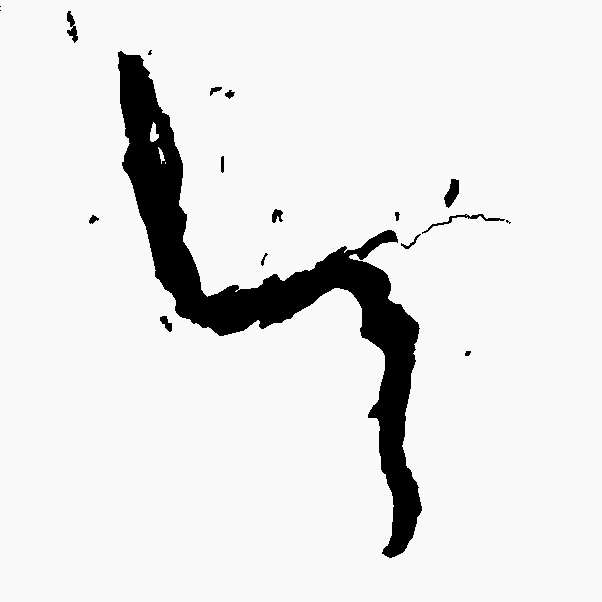

## 3. Tree sequence recapitation

``01_tree_recapitation.sh``

In [ ]:
#!/bin/bash -e
#SBATCH --job-name=01_tree_recap
#SBATCH --account=$user
#SBATCH --mem=50GB
#SBATCH --cpus-per-task=8
#SBATCH --output=%x_%j.out
#SBATCH --error=%x_%j.err
#SBATCH --time=1-00:00:00

# use OpenMP multithreading
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK

# Activate conda
source /opt/nesi/CS400_centos7_bdw/Miniconda3/23.10.0-1/etc/profile.d/conda.sh

conda activate /$Workdir/dispersal_inference/disperseNN2

cd temp_wd_k50_10k_55010763_consolidated # contains consolidated data produced by the arrays

# set up tree recapitation
i=1
while IFS= read -r line; do \
	output_path="$(dirname "$line")/$(basename "$line" .trees)_recap.trees"
	echo "python -c 'import tskit,msprime; \
		ts=tskit.load(\"$line\"); \
		Ne=len(ts.individuals()); \
		demography = msprime.Demography.from_tree_sequence(ts); \
		demography[1].initial_size = Ne; \
		ts = msprime.sim_ancestry(initial_state=ts, recombination_rate=1e-9, demography=demography, start_time=ts.metadata[\"SLiM\"][\"cycle\"],random_seed=$i,); \
		ts.dump(\"$output_path\")'" \
	>> vignette/recap_commands.txt; \
	echo "$output_path" >> vignette/tree_list.txt; \
	((i++)); \
done < /$Workdir/dispersal_inference/treeseqs_k50_10k_55010763.txt

num_threads=$SLURM_CPUS_PER_TASK

# tree recapitation
parallel -j $num_threads < vignette/recap_commands.txt
echo "DEBUG: tree recap recap"

# Deactivate the conda environment
conda deactivate

## 4. Preprocessing

We need a ``LW_rat_coords.locs`` file that has the geographic coordinates (latitude/longitude) of all our samples, in the SAME order that they appear in the VCF. We have 22 samples from around Lake Whakatipu, and will use random subsamples of 10,000 SNPs for the empirical predictions. 

In [ ]:
#!/bin/bash -e
#SBATCH --job-name=02_preprocessing_29June
#SBATCH --account=#user
#SBATCH --mem=64GB
#SBATCH --cpus-per-task=4
#SBATCH --output=%x_%j.out
#SBATCH --error=%x_%j.err
#SBATCH --hint=multithread
#SBATCH --time=02:00:00

# set up multithreading
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
export OMP_PROC_BIND=true
export OMP_PLACES=threads

# ensure that Python3.9; and disperseNN2 are installed in your envir
#e.g.
# conda install python=3.9
# pip install disperseNN2

# Activate conda
source /opt/nesi/CS400_centos7_bdw/Miniconda3/23.10.0-1/etc/profile.d/conda.sh

conda activate /$Workdir/dispersal_inference/disperseNN2

# NOTE: before running this you will need to insert the absolute file path
# e.g. "/$Workdir/dispersal_inference/temp_wd/" 
# into the beginning of every line in target_list.txt and tree_list.txt
# train with 30 and hold out 20
# you can hold out an odd number so add that additional tree seq back in. Only the training set needs to be even.

# Run Py script
disperseNN2 \
    --out /$Workdir/dispersal_inference/temp_wd_k50_10k_26may_55010763_consolidated/vignette/output_dir \
    --seed 12345 \
    --preprocess \
    --num_snps 10000 \
    --n 22 \
    --tree_list /$Workdir/dispersal_inference/temp_wd_k50_10k_26may_55010763_consolidated/vignette/recap_tree_files.txt \
    --target_list /$Workdir/dispersal_inference/temp_wd_k50_10k_26may_55010763_consolidated/vignette/target_list.txt \
    --empirical /$Workdir/dispersal_inference/temp_wd_k50_10k_26may_55010763_consolidated/vignette/LW_rat_coords \
    --hold_out 20

conda deactivate


## 4. Model training

In [ ]:
#!/bin/bash -e
#SBATCH --job-name=03_modeltraining
#SBATCH --account=$user
#SBATCH --mem=24GB
#SBATCH --cpus-per-task=8
#SBATCH --gpus-per-node=1
#SBATCH --output=%x_%j.out
#SBATCH --error=%x_%j.err
#SBATCH --time=02:00:00

# ensure that Python3.9; and disperseNN2 are installed in your envir
#e.g.
# conda install python=3.9
# pip install disperseNN2

# Activate conda
source /opt/nesi/CS400_centos7_bdw/Miniconda3/23.10.0-1/etc/profile.d/conda.sh

conda activate /$Workdir/dispersal_inference/disperseNN2

# Load CUDA and cuDNN modules
#module load CUDA/11.0.2
#module load cuDNN/8.6.0.163-CUDA-11.8.0

# Function for human-readable GPU stats
show_gpu_stats() {
    echo "==================== GPU STATUS ===================="
    echo "Time: $(date '+%Y-%m-%d %H:%M:%S')"
    
    nvidia-smi --query-gpu=name,utilization.gpu,utilization.memory,memory.used,memory.total,temperature.gpu --format=csv,noheader,nounits | while IFS=, read -r name gpu_util mem_util mem_used mem_total temp; do
        mem_percent=$((mem_used * 100 / mem_total))
        
        echo "GPU: $name"
        echo "  Compute Usage:    ${gpu_util}%"
        echo "  Memory Usage:     ${mem_util}%"
        echo "  Memory Used:      ${mem_used}MB / ${mem_total}MB (${mem_percent}%)"
        echo "  Temperature:      ${temp}°C"
        
        # Visual indicator
        if [ "$gpu_util" -gt 50 ]; then
            echo "  Status:           🔥 HIGH ACTIVITY"
        elif [ "$gpu_util" -gt 10 ]; then
            echo "  Status:           ⚡ ACTIVE"
        elif [ "$mem_used" -gt 2000 ]; then
            echo "  Status:           💤 ALLOCATED BUT IDLE"
        else
            echo "  Status:           😴 UNUSED"
        fi
    done
    echo "===================================================="
    echo ""
}

# Monitor at start to check gpu is firing
show_gpu_stats

OUTDIR="/$Workdir/dispersal_inference/temp_wd_k50_10k_55010763_consolidated/vignette/output_dir"

# for pairs we have 22 individuals in the dataset
# therefore 22 choose 2 = 231. by not setting --pairs and --pairs_encode, it will default to all pairs
# keep pairs encode at 100
# batch size must be divisible by training and validation set size. 0.2*30=6.
# use --force flag to overwrite the previous results
# make sure you use the INDEX of the GPU (0)

disperseNN2 \
            --out $OUTDIR \
            --seed 12345 \
            --train \
            --max_epochs 100 \
            --validation_split 0.2 \
            --learning_rate 1e-3 \
            --batch_size 6 \
            --threads 8 \
            --gpu 0 \
            --force \
            > ${OUTDIR}/training_history_12345.txt &

# Capture the process ID
WORK_PID=$!

# Monitor every 30 seconds while job runs
while kill -0 $WORK_PID 2>/dev/null; do
    sleep 60
    show_gpu_stats
done

wait $WORK_PID
echo "Training completed. Final GPU status:"
show_gpu_stats

# visualise training history
disperseNN2 --plot_history ${OUTDIR}/training_history_12345.txt

conda deactivate

## 5. Cross validation

In [ ]:
#!/bin/bash -e
#SBATCH --job-name=04_modelvalidation
#SBATCH --account=$user
#SBATCH --mem=4GB
#SBATCH --qos=debug
#SBATCH --cpus-per-task=4
#SBATCH --output=%x_%j.out
#SBATCH --error=%x_%j.err
#SBATCH --hint=multithread
#SBATCH --time=00:15:00

# set up multithreading
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
export OMP_PROC_BIND=true
export OMP_PLACES=threads

# ensure that Python3.9; and disperseNN2 are installed in your envir

# Activate conda
source /opt/nesi/CS400_centos7_bdw/Miniconda3/23.10.0-1/etc/profile.d/conda.sh

conda activate /$Workdir/dispersal_inference/disperseNN2

OUTDIR="/$Workdir/dispersal_inference/temp_wd_k50_10k_55010763_consolidated/vignette/output_dir"

# test with the 20 datasets held out from training. 
disperseNN2 \
            --out $OUTDIR \
            --seed 12345 \
            --predict \
            --batch_size 5 \
            --num_pred 20 \
            --threads 4

conda deactivate

## 6. Empirical prediction

In [ ]:
#!/bin/bash -e
#SBATCH --job-name=05_empirical_prediction
#SBATCH --account=$user
#SBATCH --mem=4GB
#SBATCH --qos=debug
#SBATCH --cpus-per-task=4
#SBATCH --output=%x_%j.out
#SBATCH --error=%x_%j.err
#SBATCH --hint=multithread
#SBATCH --time=00:15:00

# set up multithreading
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
export OMP_PROC_BIND=true
export OMP_PLACES=threads

# ensure that Python3.9; and disperseNN2 are installed in your envir

# Activate conda
source /opt/nesi/CS400_centos7_bdw/Miniconda3/23.10.0-1/etc/profile.d/conda.sh

conda activate /$Workdir/dispersal_inference/disperseNN2

OUTDIR="/$Workdir/dispersal_inference/temp_wd_k50_10k_55010763_consolidated/vignette/output_dir"
EMPIRICAL="/$Workdir/RRATTUS_ALL_SI/results/09_genotyped_GATK/disperseNN2_input/nomissingness_pca"

disperseNN2 \
    --out $OUTDIR \
    --seed 12345 \
    --predict \
    --empirical $EMPIRICAL \
    --num_reps 10 \
    --threads 4

conda deactivate